### Try-it 10.2: Build a Time Series Forecast Model


You have now learned to decompose a time series into seasonal and trend components and to use time series to forecast into the future using statsmodels. In this activity, your goal is to identify a new (to you) time series dataset and build a forecast using a seasonal and trend additive or multiplicative model using statsmodels.

Summarize your findings in an executive brief that explores the following:

* **Data description**: Provide a high-level overview of your data and its timeframe along with general information on your dataset
* **Forecast**: Give a description of the forecast. Describe the period that was projected and what the forecast implies about your data. Be sure to include presentation-ready plots with appropriate labels and titles.
* **Uncertainty**: Discuss the evaluation of your model on testing data, and explore the residuals. Discuss the consequence of this error for your model and forecasts. Is there still structure to uncover?

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt


import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MLAI_Haas/data/major-tech-stock-2019-2024.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6290 non-null   object 
 1   Open       6290 non-null   float64
 2   High       6290 non-null   float64
 3   Low        6290 non-null   float64
 4   Close      6290 non-null   float64
 5   Adj Close  6290 non-null   float64
 6   Volume     6290 non-null   int64  
 7   Ticker     6290 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 393.2+ KB


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2019-01-02,38.722500,39.712502,38.557499,39.480000,37.793785,148158800,AAPL
1,2019-01-03,35.994999,36.430000,35.500000,35.547501,34.029243,365248800,AAPL
2,2019-01-04,36.132500,37.137501,35.950001,37.064999,35.481926,234428400,AAPL
3,2019-01-07,37.174999,37.207500,36.474998,36.982498,35.402950,219111200,AAPL
4,2019-01-08,37.389999,37.955002,37.130001,37.687500,36.077847,164101200,AAPL


In [ ]:
#Filter for just Google stocks
df = df[df['Ticker'] == 'GOOGL']
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
5027,2023-12-22,140.770004,141.990005,140.710007,141.490005,141.327805,26514600,GOOGL
5028,2023-12-26,141.589996,142.679993,141.190002,141.520004,141.357773,16780300,GOOGL
5029,2023-12-27,141.589996,142.080002,139.889999,140.369995,140.209076,19628600,GOOGL
5030,2023-12-28,140.779999,141.139999,139.750000,140.229996,140.069244,16045700,GOOGL
5031,2023-12-29,139.630005,140.360001,138.779999,139.690002,139.529861,18727200,GOOGL


In [ ]:
#Drop all columns except "Date" and  "Adj Close"
df=df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Ticker'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 3774 to 5031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1258 non-null   object 
 1   Adj Close  1258 non-null   float64
dtypes: float64(1), object(1)
memory usage: 29.5+ KB


In [ ]:
#Set time index
#df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Set the frequency to daily
df = df.asfreq('D')
df.head()


,Adj Close
Date,
2019-01-02,52.673550
2019-01-03,51.214722
2019-01-04,53.841705
2019-01-05,NaN
2019-01-06,NaN


In [ ]:
# Fill missing values using forward propagation
df.fillna(method='ffill', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1823 entries, 2019-01-02 to 2023-12-29
Freq: D
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1823 non-null   float64
dtypes: float64(1)
memory usage: 28.5 KB


<ipython-input-239-839e6ef06acc>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
# Ensure the index is a DatetimeIndex
#df.index = pd.to_datetime(df.index)

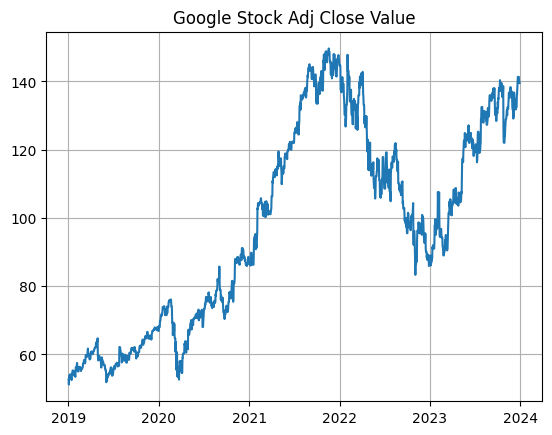

In [ ]:
plt.plot(df['Adj Close'])
plt.title('Google Stock Adj Close Value')
plt.grid();

Text(0.5, 1, 'Google Stock Price Time Series Decomposition')

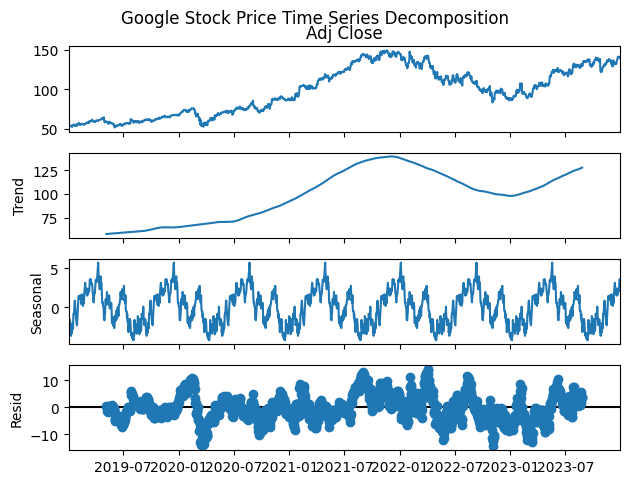

In [ ]:
# Decompose time series data
df_decomp = seasonal_decompose(df['Adj Close'], period=250)
fig_decomp = df_decomp.plot()
fig_decomp.suptitle("Google Stock Price Time Series Decomposition",  y='1')
#fig_decomp.savefig("SalesDecomp.png")

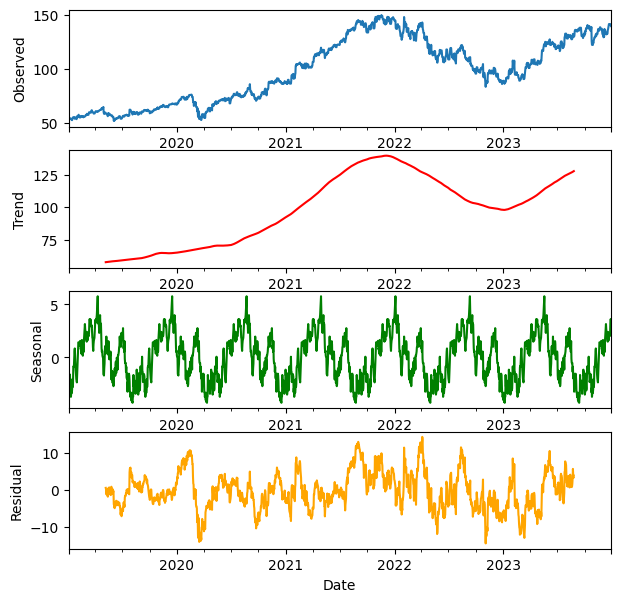

In [ ]:
# Display plots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(7,7))

df_decomp.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

df_decomp.trend.plot(ax=ax2, color="red")
ax2.set_ylabel('Trend')

df_decomp.seasonal.plot(ax=ax3, color="green")
ax3.set_ylabel('Seasonal')

df_decomp.resid.plot(ax=ax4, color="orange")
ax4.set_ylabel('Residual')

#plt.tight_layout()
plt.show()

### Forecast

In [ ]:
df_hist = df[:'2023-01-01']
df_futr = df['2023-01-02':]
print('Historical:')
print(df_hist.tail())
print('=========\nFuture:')
print(df_futr.head())

Historical:
            Adj Close
Date                 
2022-12-28  85.921387
2022-12-29  88.348602
2022-12-30  88.128860
2022-12-31  88.128860
2023-01-01  88.128860
Future:
            Adj Close
Date                 
2023-01-02  88.128860
2023-01-03  89.017838
2023-01-04  87.979027
2023-01-05  86.101181
2023-01-06  87.239868


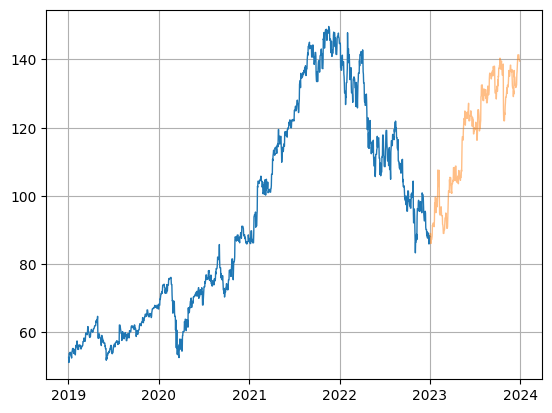

In [ ]:
plt.plot(df_hist,linewidth=1)
plt.plot(df_futr,linewidth=1,alpha=0.5)
plt.grid()

In [ ]:
stl = STL(df_hist['Adj Close'], period = 250)
results = stl.fit()

Text(0.5, 1.0, 'Trend with Google Stock Data')

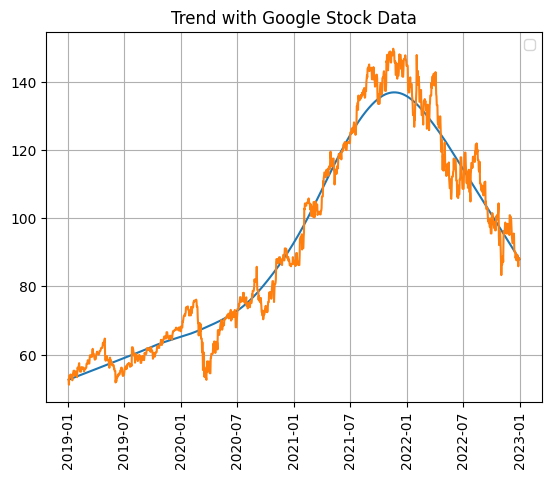

In [ ]:
## Plot Trend
plt.plot(results.trend)
plt.plot(df_hist)
plt.grid()
plt.legend()
plt.xticks(rotation = 90);
plt.title('Trend with Google Stock Data')

Text(0.5, 1.0, 'Seasonal + Trend in comparison to actual for a subset of NASDAQ Data')

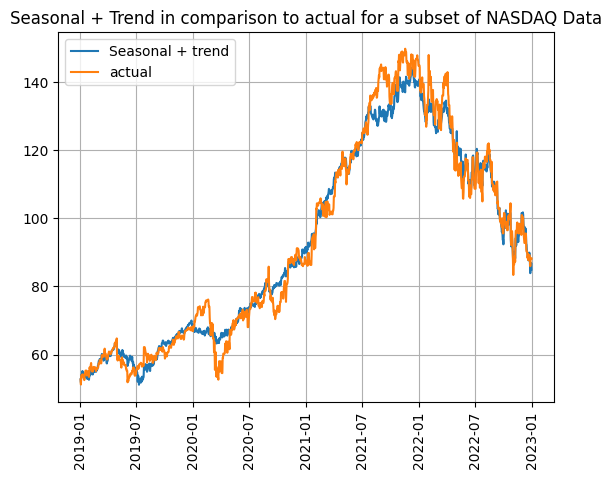

In [ ]:
# Plot season and trend
season_and_trend = results.seasonal + results.trend

plt.plot(season_and_trend['2008':], label = 'Seasonal + trend')
plt.plot(df_hist['2008':], label = 'actual')
plt.grid()
plt.legend()
plt.xticks(rotation = 90);
plt.title('Seasonal + Trend in comparison to actual for a subset of NASDAQ Data')

Text(0.5, 1.0, 'Residue with Google Stock Data')

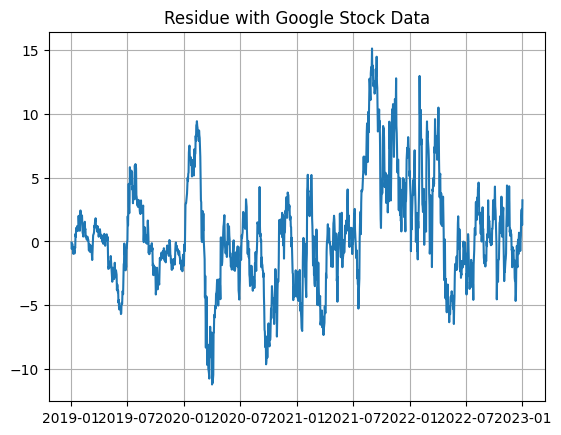

In [ ]:
plt.plot(results.resid)
plt.grid()
plt.title('Residue with Google Stock Data')

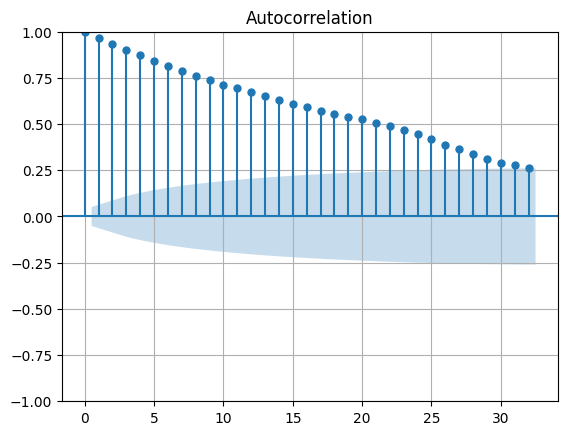

In [ ]:
tsplots.plot_acf(results.resid)
plt.grid()

In [ ]:
df_hist.index.freq = pd.infer_freq(df_hist.index)

In [ ]:
# Now pass the model instance to STLForecast
stlf = STLForecast(df['Adj Close'], arima_model, model_kwargs={}, period=10)


In [ ]:
!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
hyper_params = auto_arima(df.dropna(),trace=True)
hyper_params.summary()
stlf = STLForecast(df['Adj Close'], ARIMA, model_kwargs = {'order':(1,1,0), 'trend':"t"}, period = 10)
stlf_results = stlf.fit()
forecast = stlf_results.forecast()
pred_error = df['Adj Close'] - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())

print(mae)
print(rmse)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6961.594, Time=10.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6961.378, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6961.214, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6961.197, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6960.930, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6958.916, Time=8.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6960.633, Time=7.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6964.665, Time=6.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6963.168, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6963.187, Time=1.36 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=6959.506, Time=0.58 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 36.056 seconds


AttributeError: model must expose a ``fit``  method.

In [ ]:
stlf = STLForecast(df['Adj Close'], ARIMA, model_kwargs = {'order':(1,1,1)}, period = 10)
stlf_results = stlf.fit()
forecast = stlf_results.forecast()
pred_error = df['Adj Close'] - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())
print(mae)
print(rmse)

nan
nan


In [ ]:
df.head()

,Adj Close
Date,
2019-01-02,52.673550
2019-01-03,51.214722
2019-01-04,53.841705
2019-01-05,53.841705
2019-01-06,53.841705


In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA

# include the Seasonal Arima Model for forecasting, SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

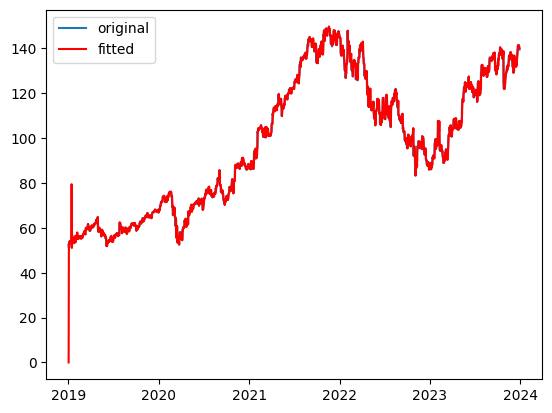

In [ ]:
model = SARIMAX(df['Adj Close'], trend='n', order=(0,1,0), seasonal_order=(1,1,1,12))
results_ARIMA = model.fit(disp=-1)
plt.plot(df['Adj Close'], label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='fitted')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-df)**2))
plt.legend()

In [ ]:
stlf = STLForecast(df_hist['Adj Close'], ARIMA, model_kwargs={'order':(0, 1, 1), 'trend':"t",})
#fit model using historical data
stlf_results = stlf.fit()
#produce forecast for future data
forecast = stlf_results.forecast(len(df_futr))

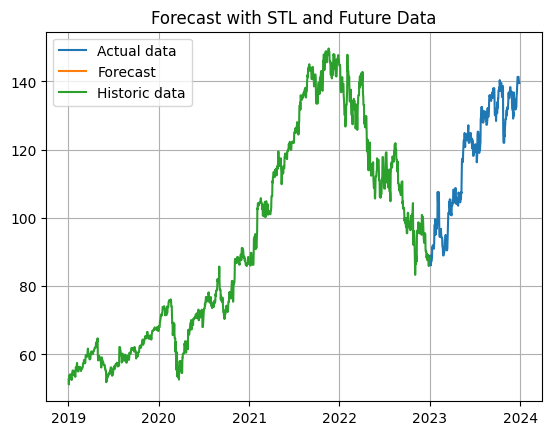

In [ ]:
plt.plot(df_futr, label = 'Actual data')
plt.plot(forecast, label = 'Forecast')
plt.plot(df_hist, label = 'Historic data')
plt.legend()
plt.title('Forecast with STL and Future Data')
plt.grid();

In [ ]:
X_train=int(len(df)*0.8)
X_test=len(df)-X_train
y_train=df.iloc[:X_train]
y_test=df.iloc[X_train:]

In [ ]:
pred_error = nasdaq_futr.value - forecast
mae = np.abs(pred_error).mean()
rmse = np.sqrt((pred_error**2).mean())

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

NameError: name 'nasdaq_futr' is not defined

### Uncertainty

As can be seen from the plot of seasonal+trend plot. The model worked well with the testing data. Based on the autocorrelation coefficients, the model is not stationary. More work needs to be be done to fine tune the model.

As expected the forecasted values don't match observed values in the development set.

In [ ]:
# Check if the start date is within the range of the index
print(f"Dataframe index range: {df.index.min()} - {df.index.max()}")

Dataframe index range: 2019-01-02 00:00:00 - 2023-12-29 00:00:00


In [ ]:
#convert our data series back into a dataframe
#df = pd.DataFrame(df)
# Add a forecast column to the dataframe that includes our predictions from the model
df['forecast'] = results_ARIMA.predict(start = '2022-06-03', end= '2023-12-29', dynamic= True)


df.tail()

,Adj Close,forecast
Date,,
2023-12-25,141.327805,147.343254
2023-12-26,141.357773,147.239924
2023-12-27,140.209076,147.072373
2023-12-28,140.069244,147.471081
2023-12-29,139.529861,147.423722


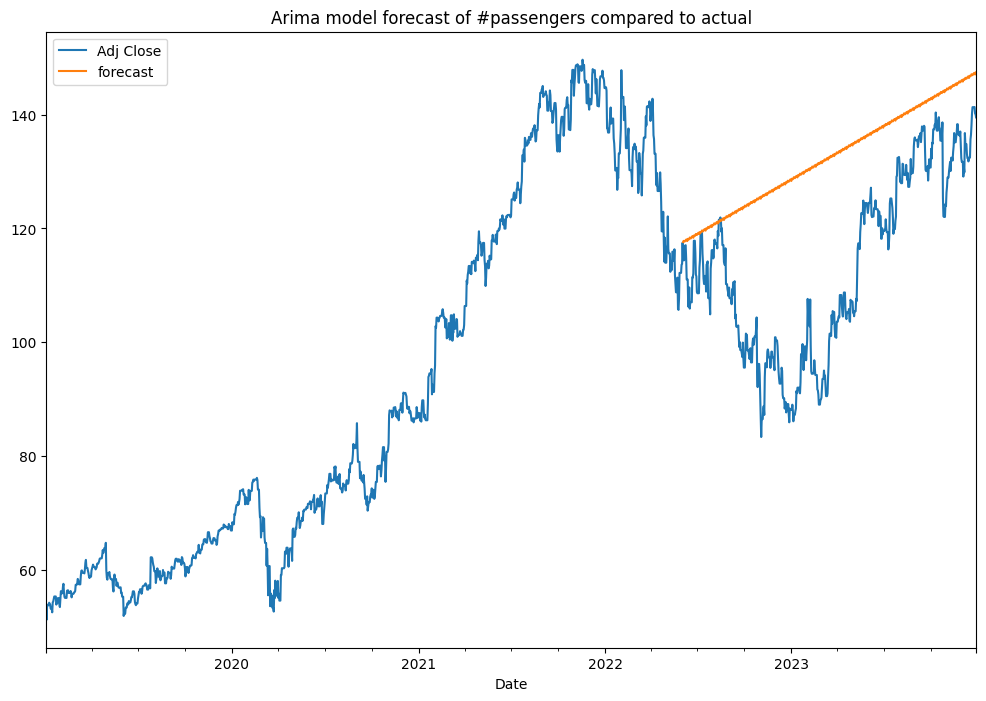

In [ ]:
# Plot the Dataframe data
df[['Adj Close', 'forecast']].plot(figsize=(12, 8))
# Add a title
plt.title('Arima model forecast of #passengers compared to actual')
# Show the plot
plt.show()

In [ ]:
adf=sm.tsa.stattools.adfuller(df['Adj Close'], autolag='AIC')
adf

(-1.0520458751318045,
 0.7338119654718598,
 14,
 1808,
 {'1%': -3.433972018026501,
  '5%': -2.8631399192826676,
  '10%': -2.5676217442756872},
 6881.962368963934)

In [ ]:
adf_test = adf(alpha=.05)
p_val, should_diff = adf_test.should_diff(df['Adj Close'])
print(f"p-value: {p_val}")
print(f"should_diff: {should_diff}")
adf

TypeError: 'tuple' object is not callable

In [ ]:
# Perform the ADF test using the original function from statsmodels
adf_result = sm.tsa.stattools.adfuller(df['Adj Close'], autolag='AIC')

# Assuming you have a custom class named 'adf_test' for hypothesis testing
adf_test_instance = adf_test(alpha=.05) # Initialize your adf_test class instance
p_val, should_diff = adf_test_instance.should_diff(df['Adj Close']) # Call should_diff on the instance

print(f"p-value: {p_val}")
print(f"should_diff: {should_diff}")
print(adf_result) # Print the original adf result

NameError: name 'adf_test' is not defined